In [82]:
using Random
using Distributions
using LinearAlgebra
include("../../Inversion/Plot.jl")
include("../../Inversion/RWMCMC.jl")
include("../../Inversion/SMC.jl")
include("../../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [83]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

## Rosenbrock banana likelihood function

We will explore the question with the following inverse problem 

$$
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} 
\qquad
\theta_{ref} = 
\begin{bmatrix}
1\\
1
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_{\eta_1}^2 & 0\\
0 & \sigma_{\eta_2}^2
\end{bmatrix} 
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the "uninformative" Gaussian prior $\mathcal{N}(0, 10^2 I)$.
     

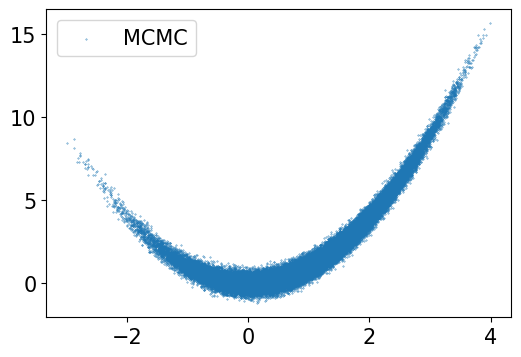

PyObject <matplotlib.legend.Legend object at 0x1dc08e670>

In [84]:
function func_G(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [θ₂ - θ₁^2; θ₁]
end

function log_prior(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -(θ₁^2 + θ₂^2)/(2σ0^2)
end

function log_Rosenbrock(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    y₁, y₂ = func_G(θ)
    return -(y[1] - y₁)^2/(2ση₁^2) - (y[2] - y₂)^2/(2ση₂^2)  + log_prior(θ)
end

μ0, σ0 = [0.0;0.0], 10.0
Σ0 = [σ0^2 0.0;0.0  σ0^2]


ση₁, ση₂ = sqrt(1/10), sqrt(1)
Σ_η = [ση₁^2  0.0;  0.0  ση₂^2]
y = [0.0; 1.0]


# compute posterior distribution by MCMC

step_length = 0.1
n_ite = 10^7
us = RWMCMC_Run(log_Rosenbrock, μ0, step_length, n_ite);
everymarker = 100
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
n_burn_in, n_end = div(n_ite, 10), n_ite
ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
ax.legend()

## Gaussian Mixture Kalman Inversion

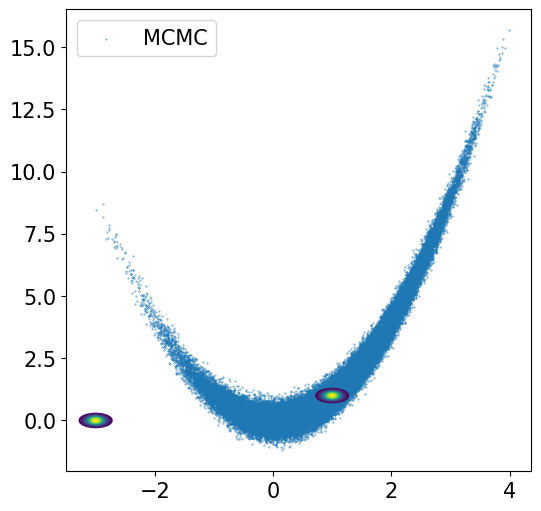

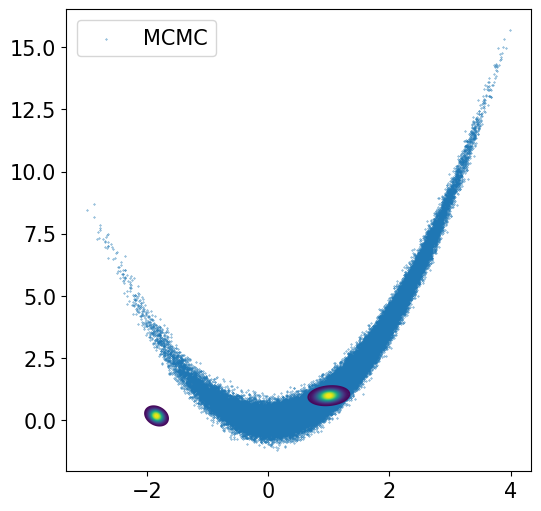

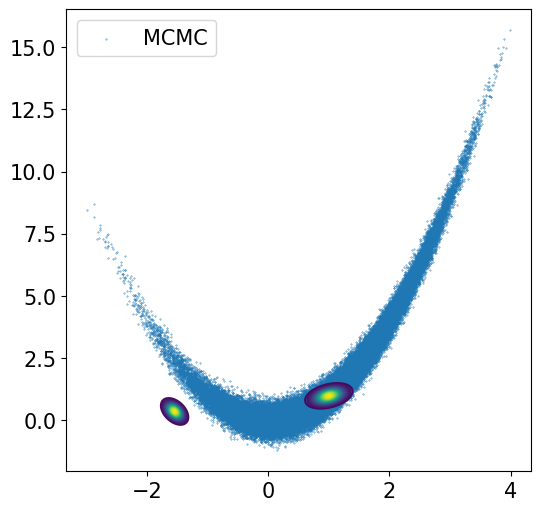

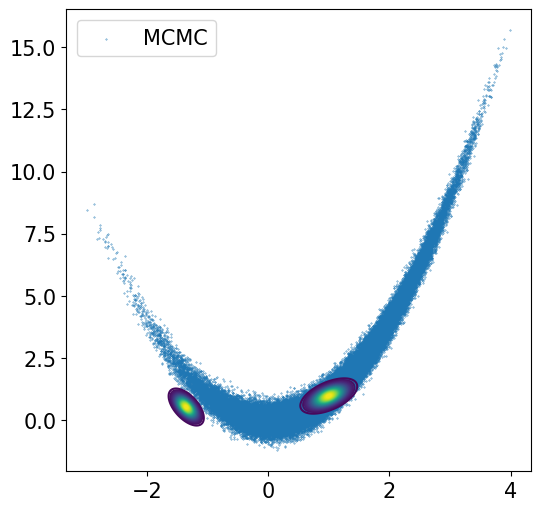

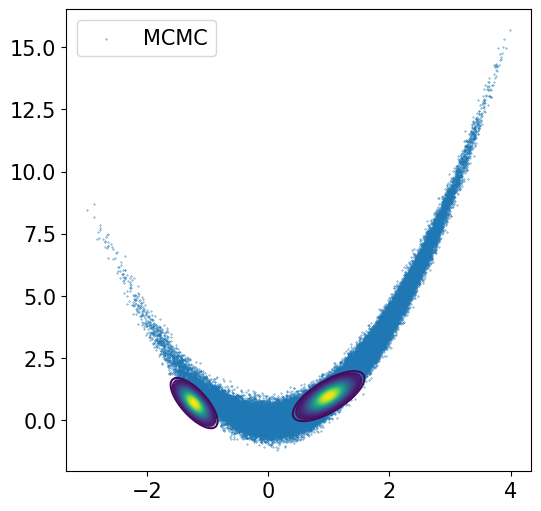

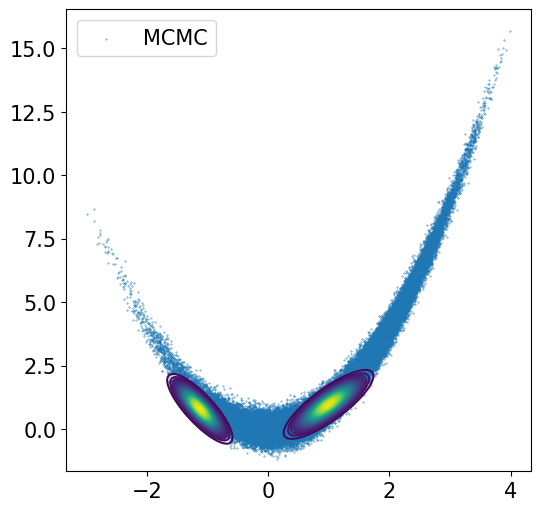

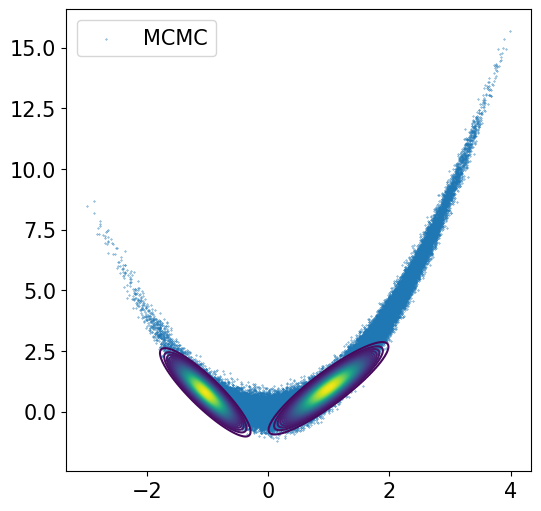

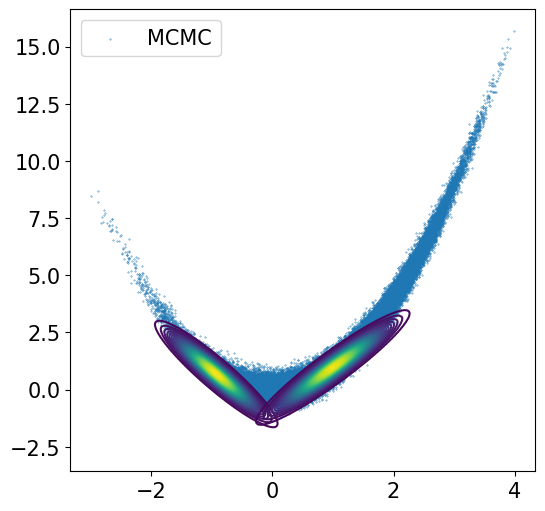

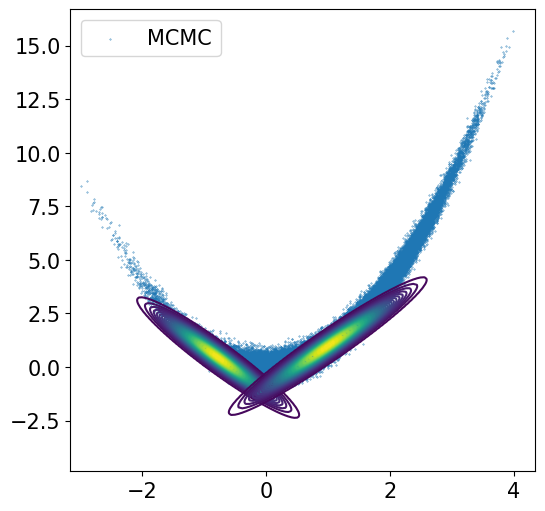

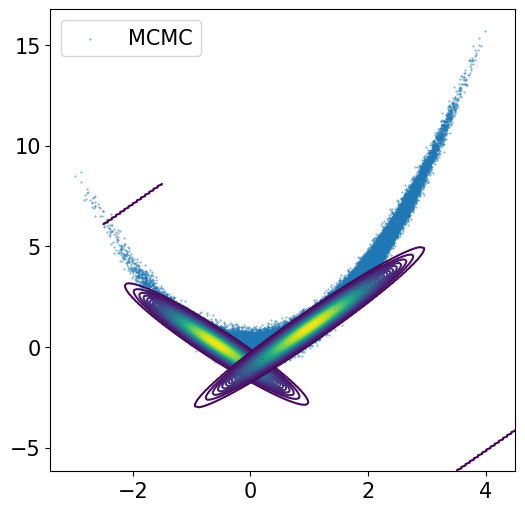

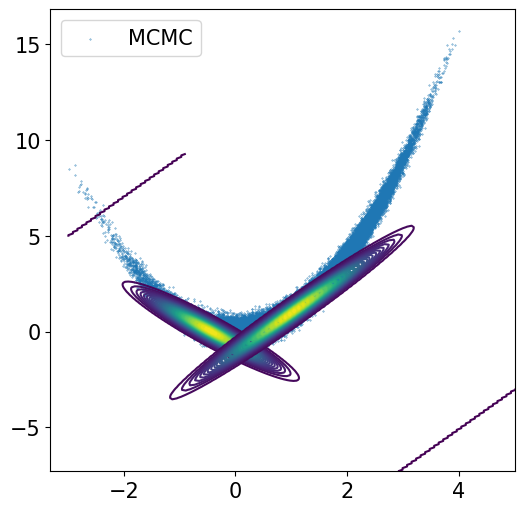

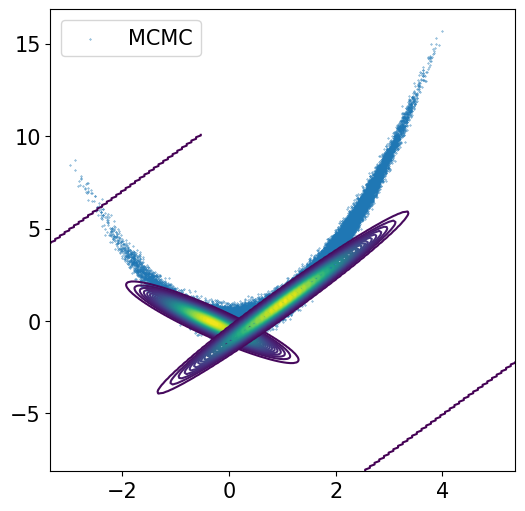

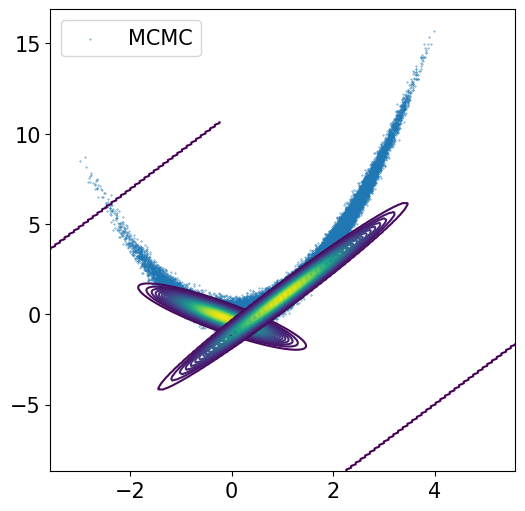

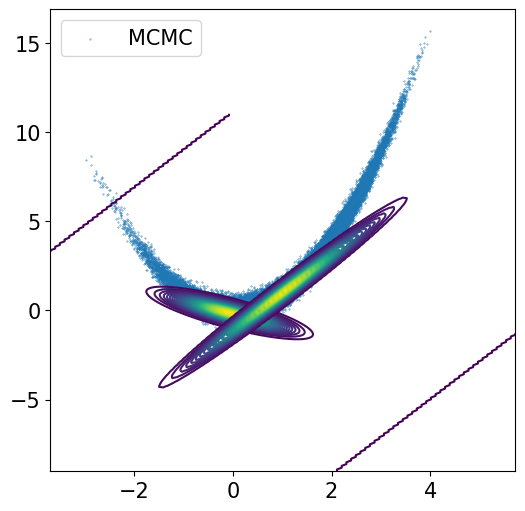

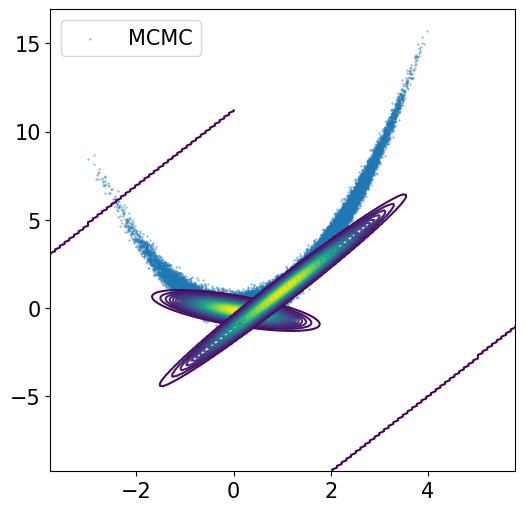

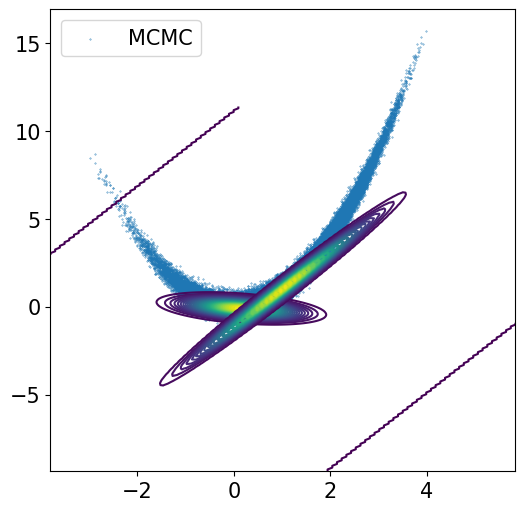

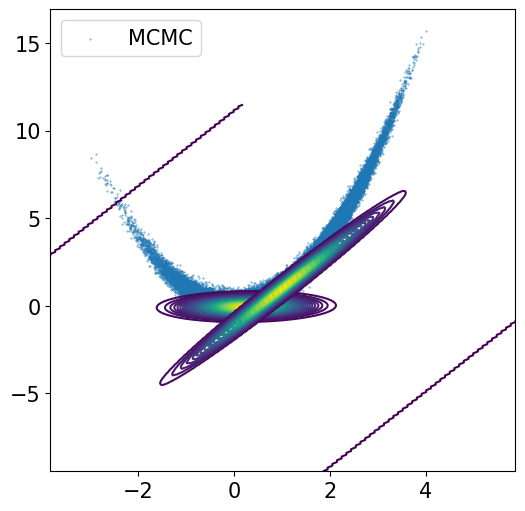

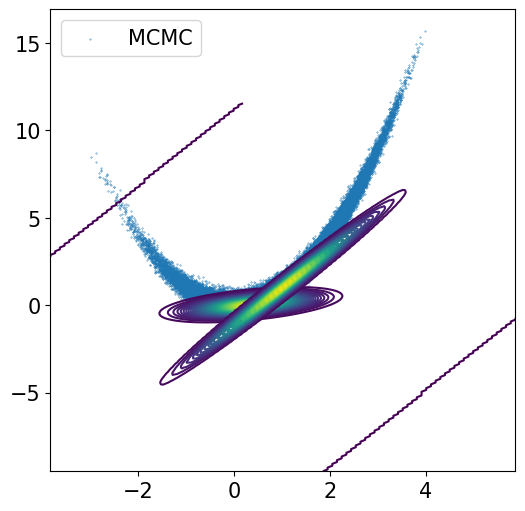

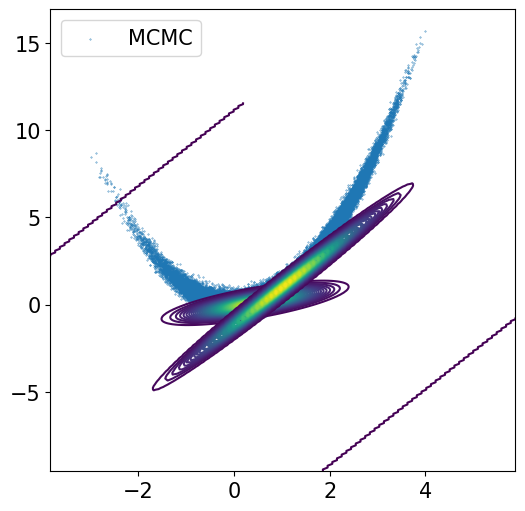

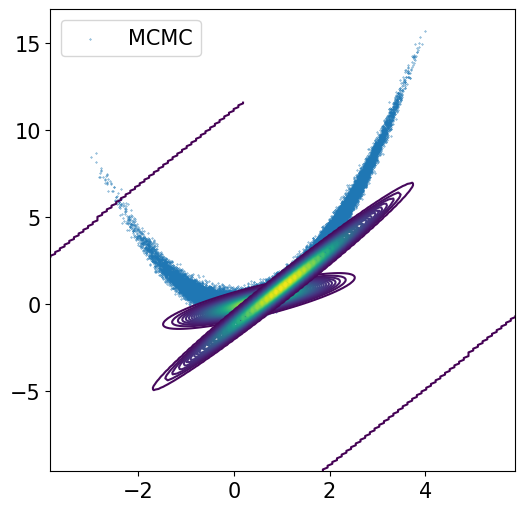

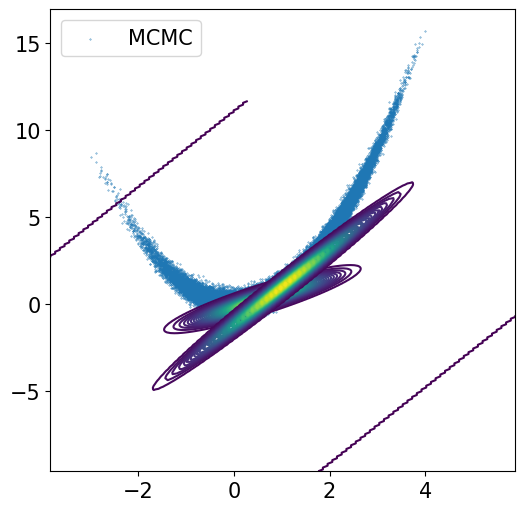

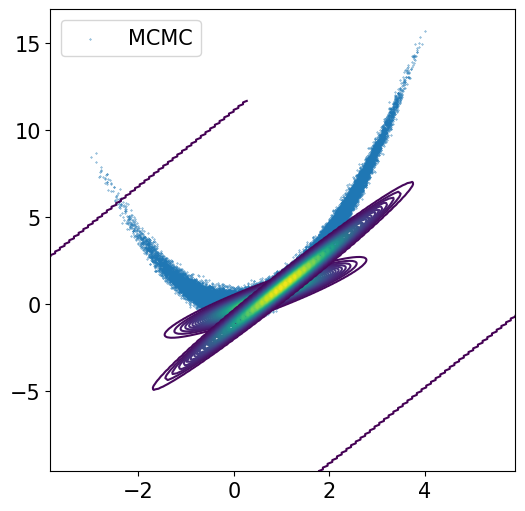

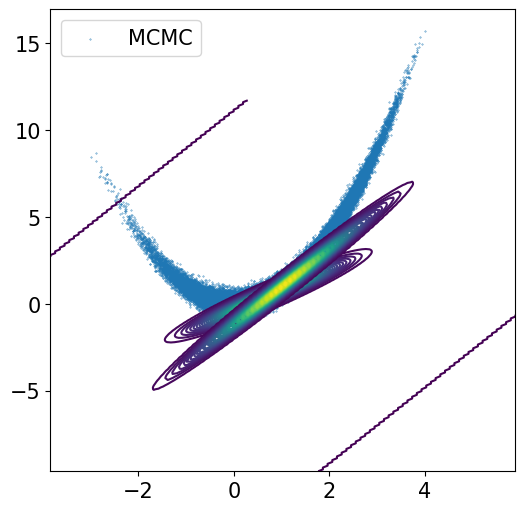

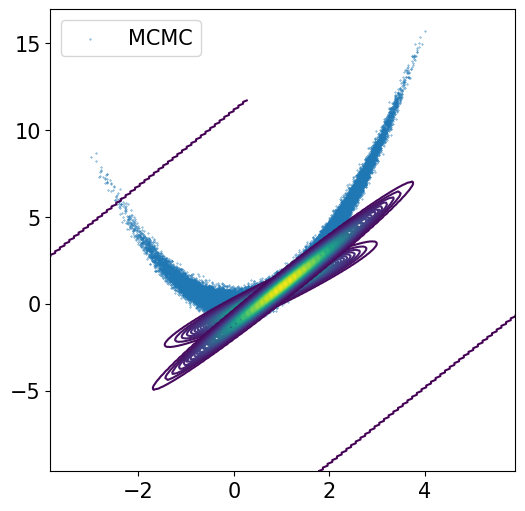

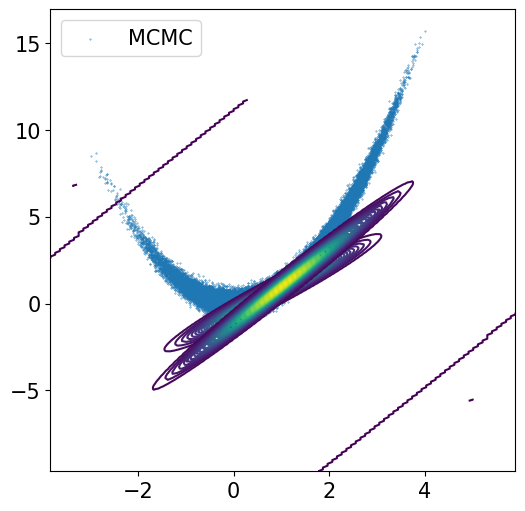

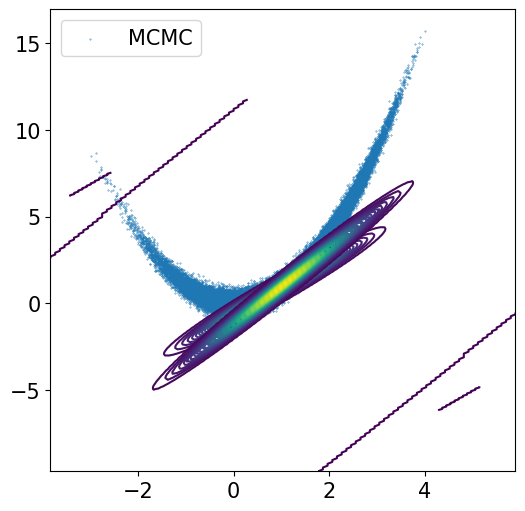

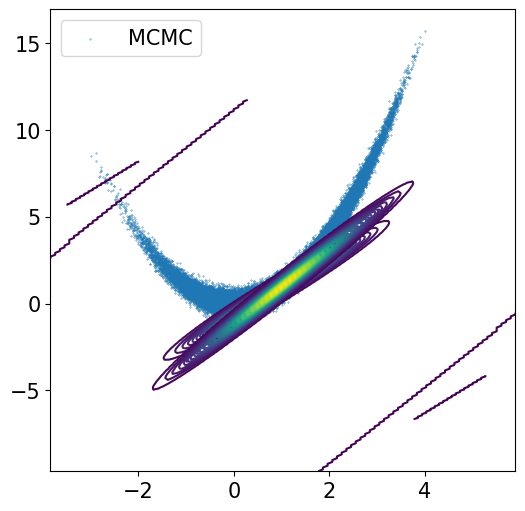

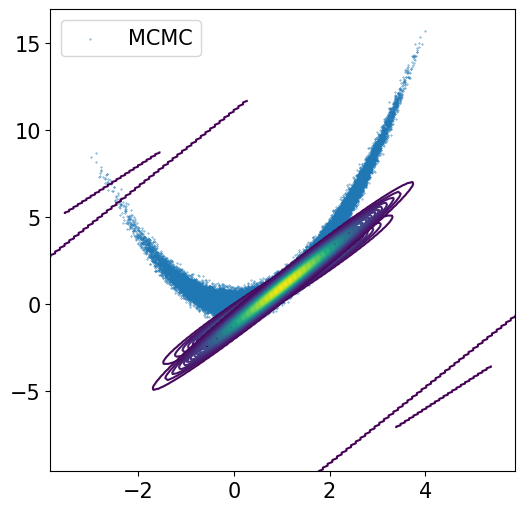

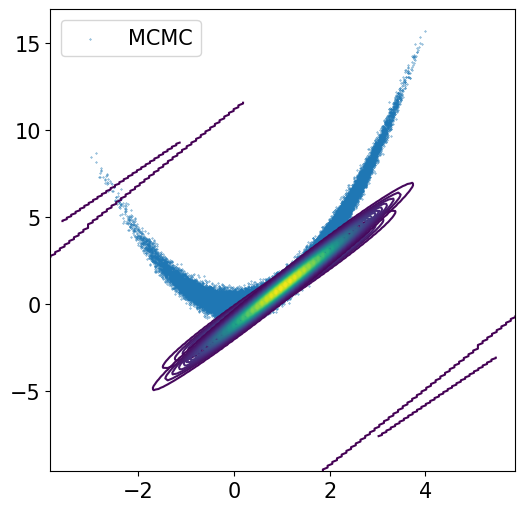

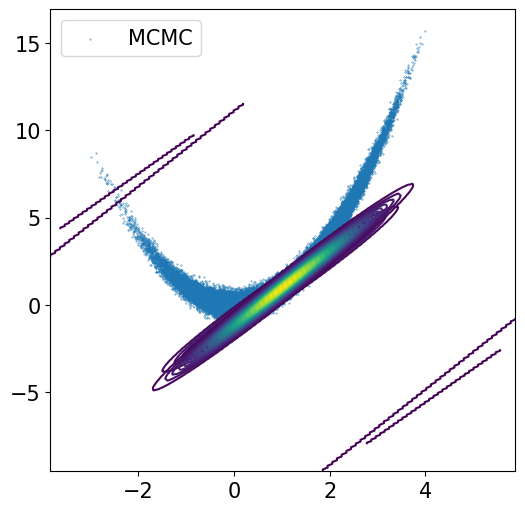

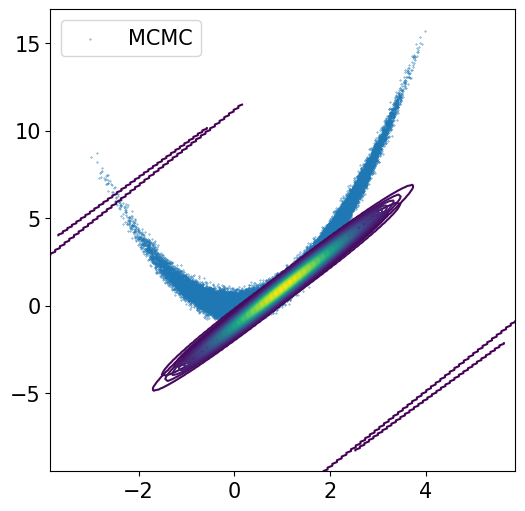

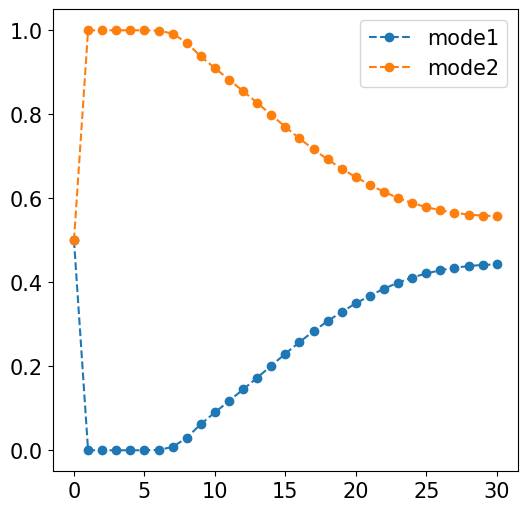

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("prediction step  : θ_mean = ", [-3.0 0.0; 1.0 1.0], " θ_p_mean = ", [-2.9966190105365387 -0.0064715845193332126; 1.0033809894634618 0.9935284154806673])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:560
┌ Info: ("prediction step  : θ_mean = ", [-1.8420486450217428 0.18138295473297383; 1.001514537909885 0.9943016123370252], " θ_p_mean = ", [-1.839736227710118 0.17139728636253693; 1.0055903825874952 0.9863192263472559])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:560
┌ Info: ("prediction step  : θ_mean = ", [-1.544057875561532 0.3619817981893013; 1.0014583777130854 0.9880804010921544], " θ_p_mean = ", [-1.541287786444649 0.34778672070013367; 1.0062853774133393 0.9789679416921349])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inv

PyObject <matplotlib.legend.Legend object at 0x1db772910>

In [85]:
include("../../Inversion/KalmanInversion.jl")

function forward(s_param::Setup_Param, θ::Array{Float64,1})
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)

N_y, N_θ = 2, 2
# compute posterior distribution by UKI
update_freq = 1
N_iter = 30
N_modes = 2
θ0_w  = ones(N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

θ0_mean[1, :]    .= [-3.0 ; 0]
θθ0_cov[1, :, :] .= 0.1^2*diagm(ones(N_θ))
θ0_mean[2, :]    .= [1.0 ; 1.0]
θθ0_cov[2, :, :] .= 0.1^2*diagm(ones(N_θ))
# θ0_mean[3, :]    .= [0.0 ; 3.0]
# θθ0_cov[3, :, :] .= 0.1^2*diagm(ones(N_θ))

s_param_aug = Setup_Param(N_θ, N_y+N_θ)
y_aug = [y ; μ0]
Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
γ = 1.0
# Δt = γ/(1+γ)
ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")



# visualization 

# Visualize different iterations
plot_every = 1
Run_MCMC = true
for iter  = 1:plot_every:length(ukiobj.θ_mean)
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 
    
    
    if Run_MCMC
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
    end

    # plot UKI results 
    Nx = 100; Ny = 200
    for i =1:N_modes
        uki_θ_mean = ukiobj.θ_mean[iter][i, :]
        uki_θθ_cov = ukiobj.θθ_cov[iter][i, :, :]
        X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
        ax.contour(X, Y, Z, 50)
    end

    ax.legend()
end


nrows, ncols = 1, 1
fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
θ_w = exp.(hcat(ukiobj.logθ_w...))
for i =1:N_modes
    ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
end
ax.legend()


## Double banana likelihood function

We will explore the question with the following inverse problem 

$$
\begin{align*}
y = 
\log
\Bigl(
(1 - \theta_{(1)})^2 + 100(\theta_{(2)} - \theta_{(1)}^2)^2
\Bigr)
+\eta
\qquad 
\theta_{ref} = 
\begin{bmatrix}
0\\
0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
0.3^2 
\end{bmatrix} 
\end{align*}
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the Gaussian prior $\mathcal{N}(0, 1^2 I)$.
     

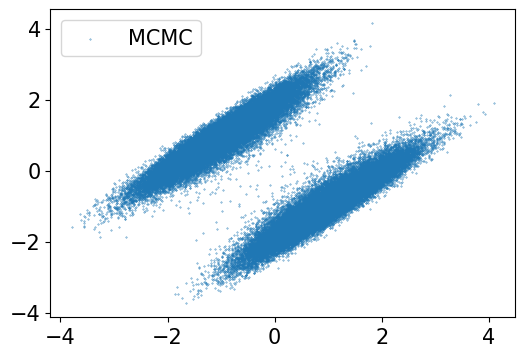

┌ Info: ("y = ", [4.2297])
└ @ Main In[94]:23


PyObject <matplotlib.legend.Legend object at 0x1dcb379a0>

In [94]:
function func_G(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [(θ₂ - θ₁)^2;]
end

function log_prior(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -(θ₁^2 + θ₂^2)/σ0^2/2
end

function log_double_banana(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -(y[1] - func_G(θ)[1])^2/ση^2/2 + log_prior(θ)
end

μ0, σ0 = [0.0;0.0], 1.0
Σ0 = [σ0^2 0.0;0.0  σ0^2]

ση = 1.0
Σ_η = [ση^2;;]
y = [4.2297;]

@info "y = ", y

# compute posterior distribution by MCMC

step_length = 0.1
n_ite = 10^7
us = RWMCMC_Run(log_double_banana, μ0, step_length, n_ite);
everymarker = 100
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
n_burn_in, n_end = div(n_ite, 10), n_ite
ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
ax.legend()

┌ Info: ([1.0;;], [1.0 0.0; 0.0 1.0])
└ @ Main In[96]:25
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("prediction step  : θ_mean = ", [-3.0 0.0; 0.0 3.0; 2.0 -3.0], " θ_p_mean = ", [-2.9966190105365387 -0.0064715845193332126; 0.003380989463461923 2.9935284154806663; 2.0033809894634613 -3.0064715845193337])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:560
┌ Info: ("prediction step  : θ_mean = ", [-2.8097804237844386 -0.16357660102336732; 0.16051660591855088 2.8067204286796192; 1.3071768066838074 -2.3003358116896226], " θ_p_mean = ", [-2.8055444398681084 -0.17029488645150206; 0.16475258983488117 2.800002143251484; 1.311063410155949 -2.30484749325232])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:560
┌ Info: ("prediction step  : θ_mean = ", [-2.667241229717815 -0.25081480871209605; 0.245380

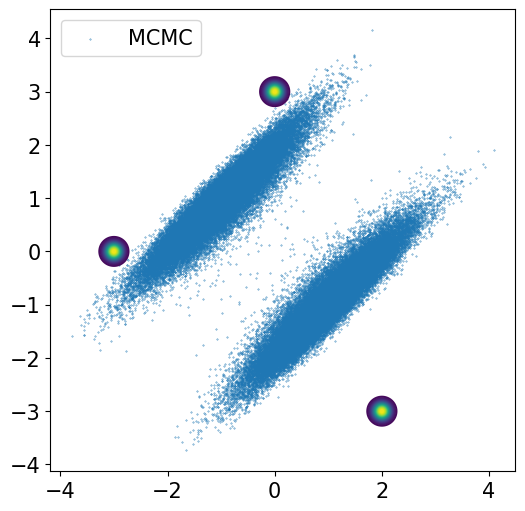

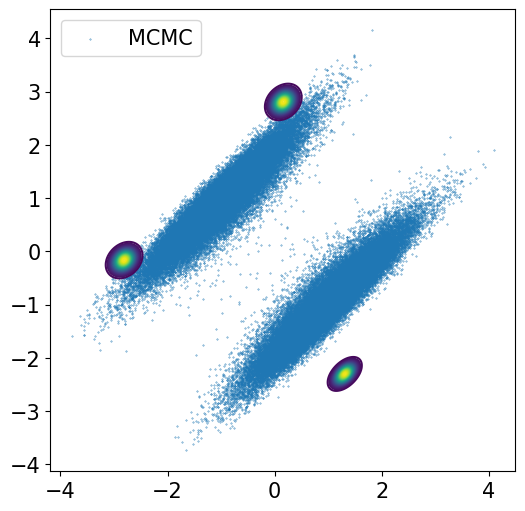

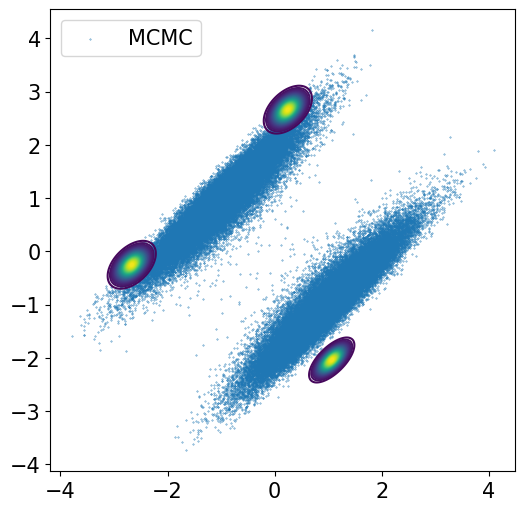

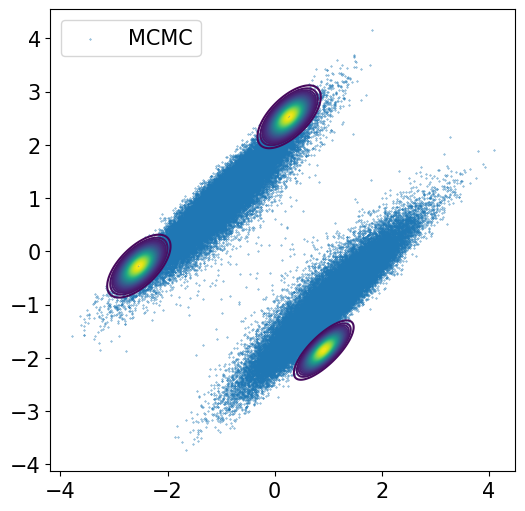

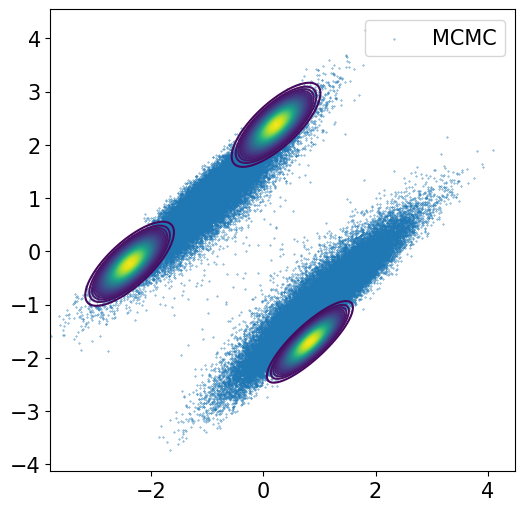

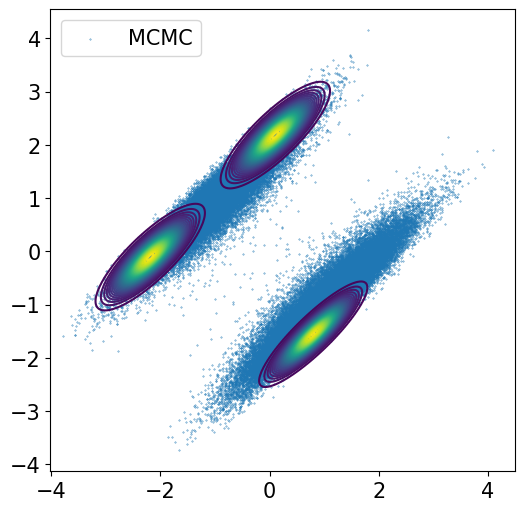

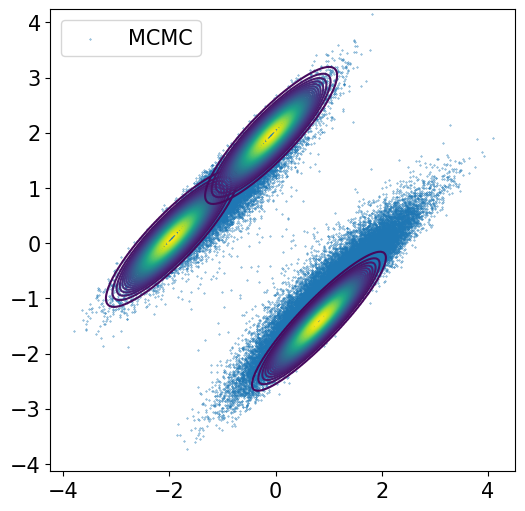

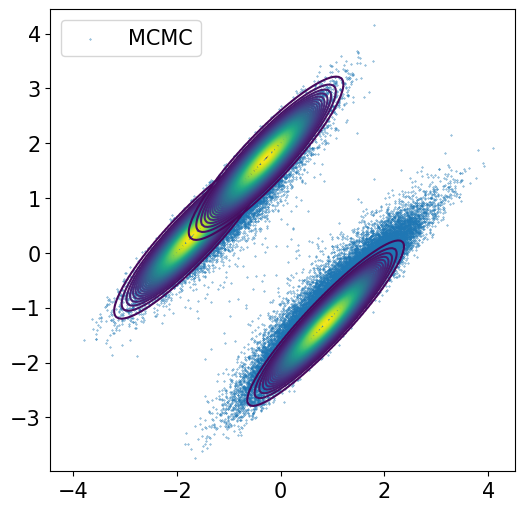

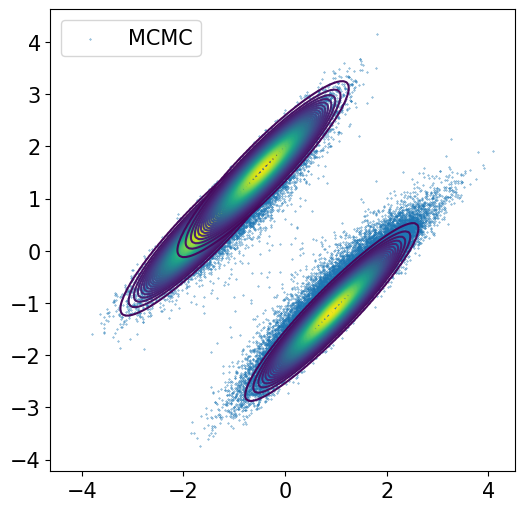

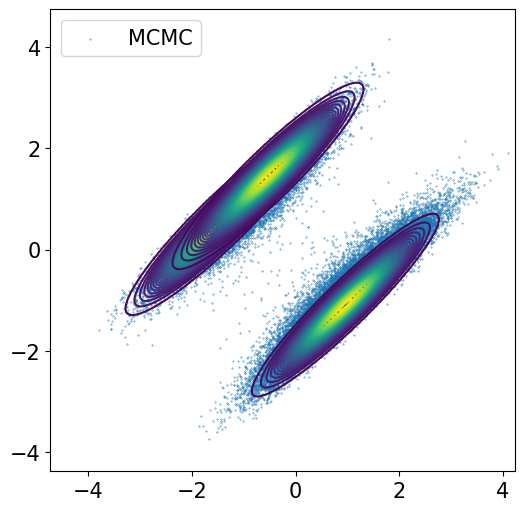

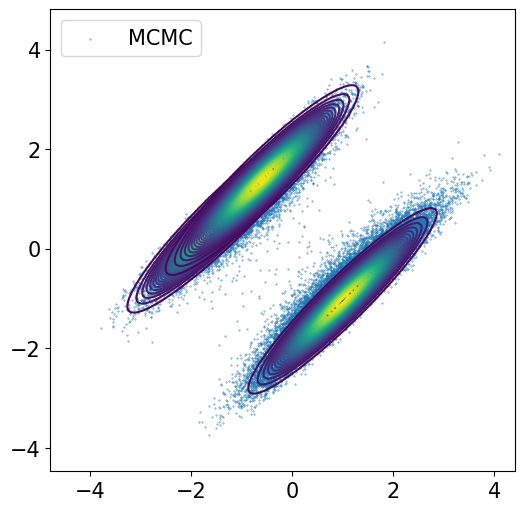

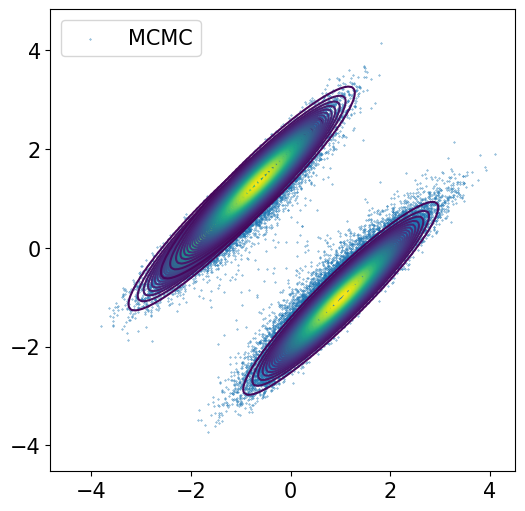

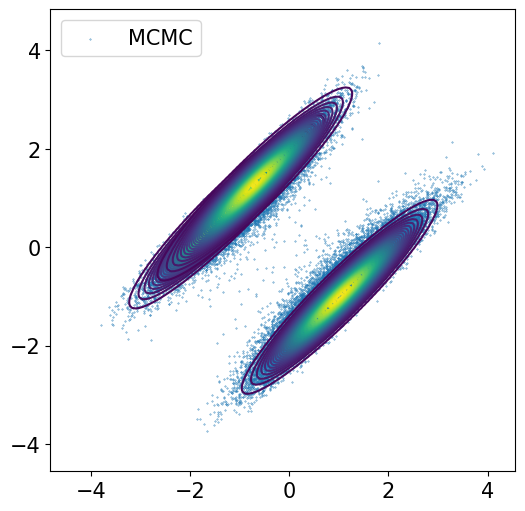

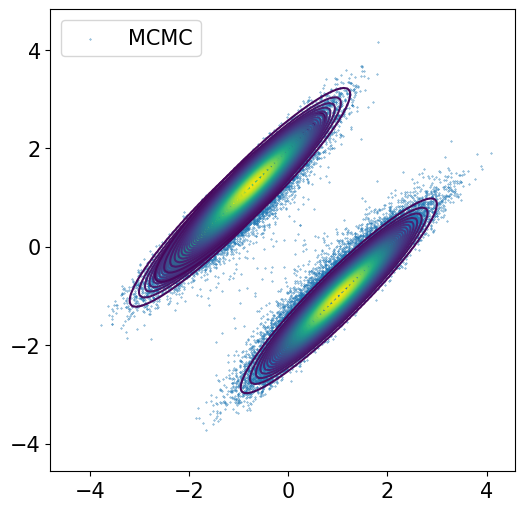

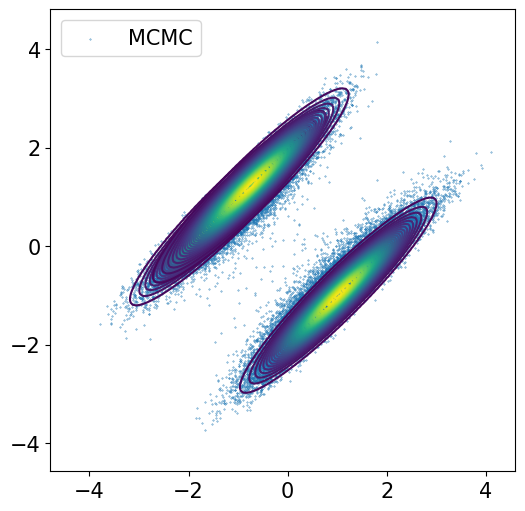

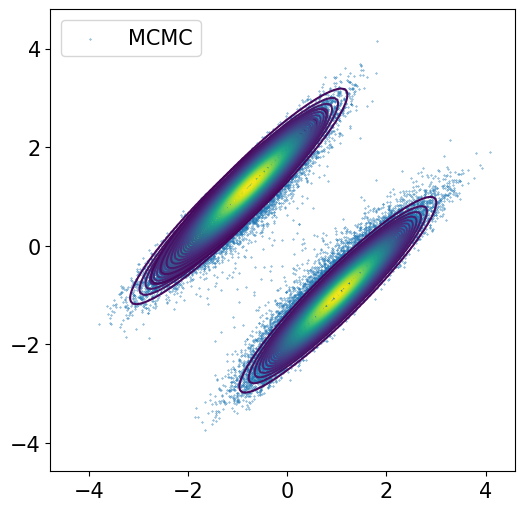

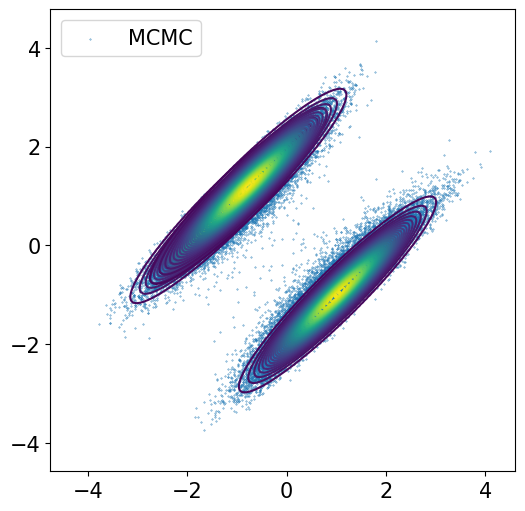

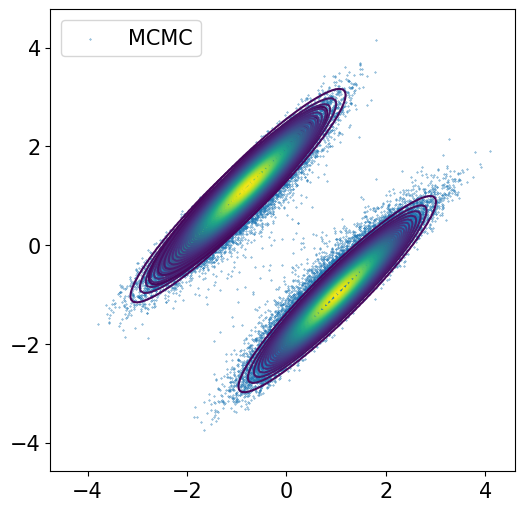

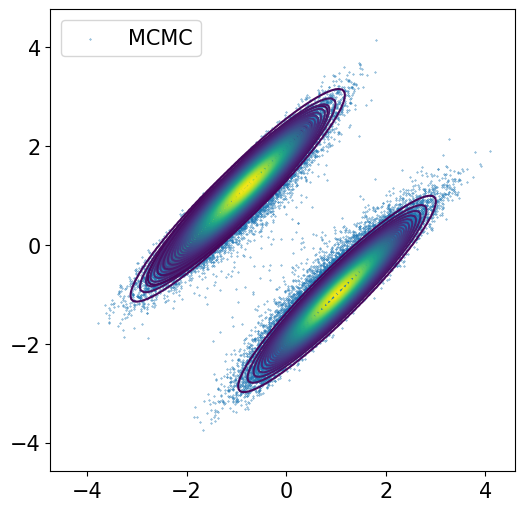

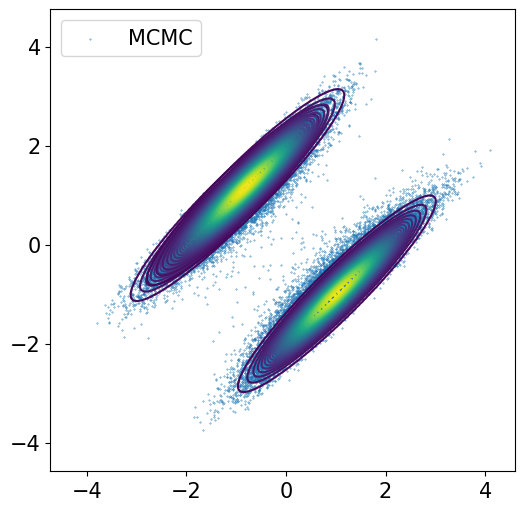

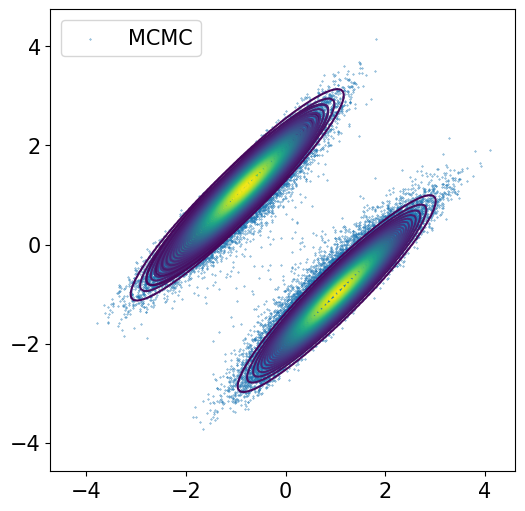

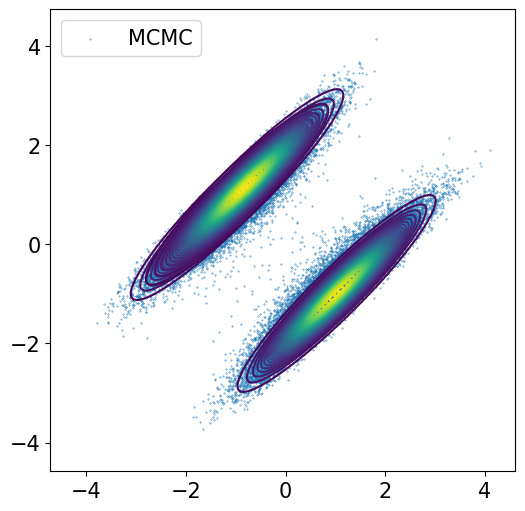

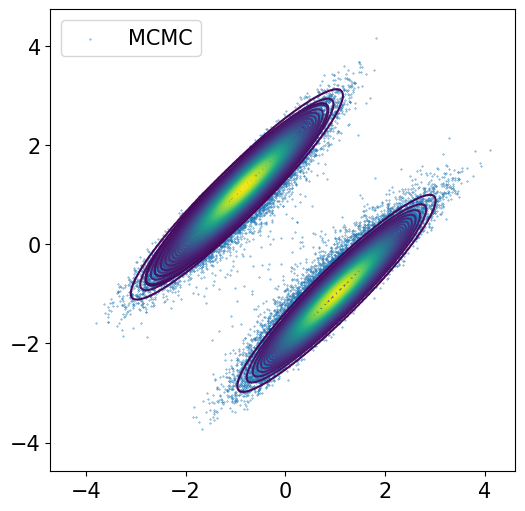

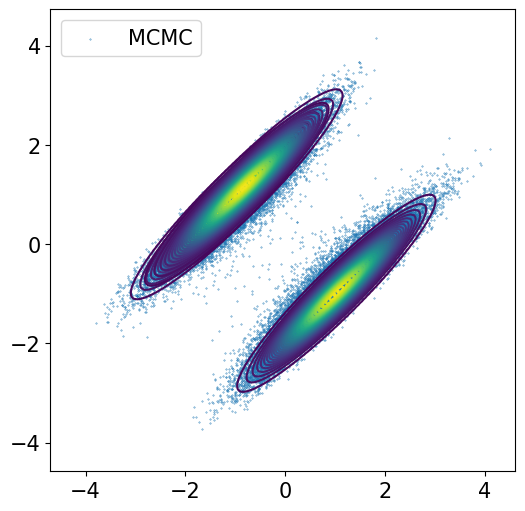

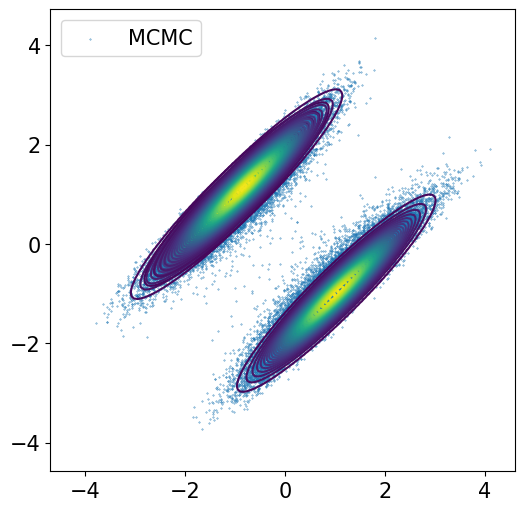

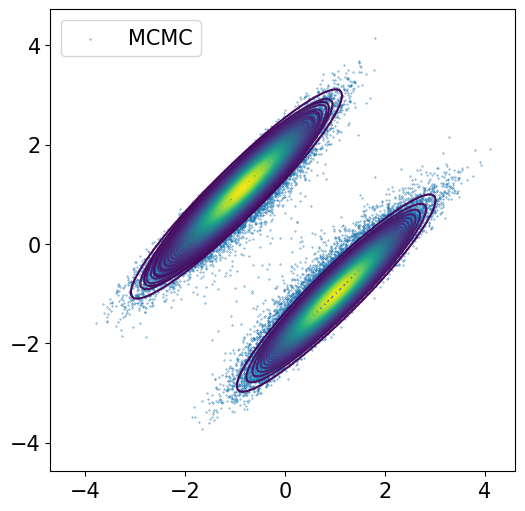

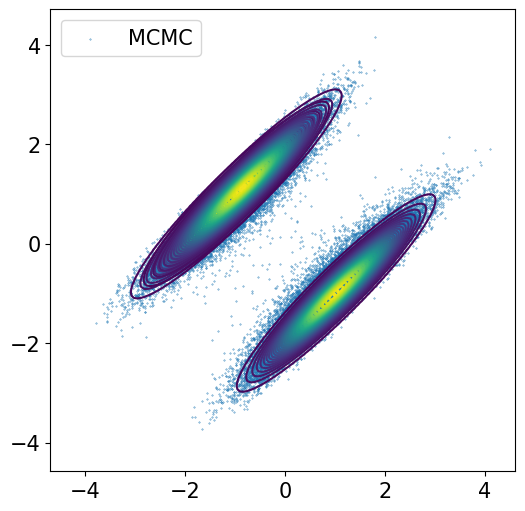

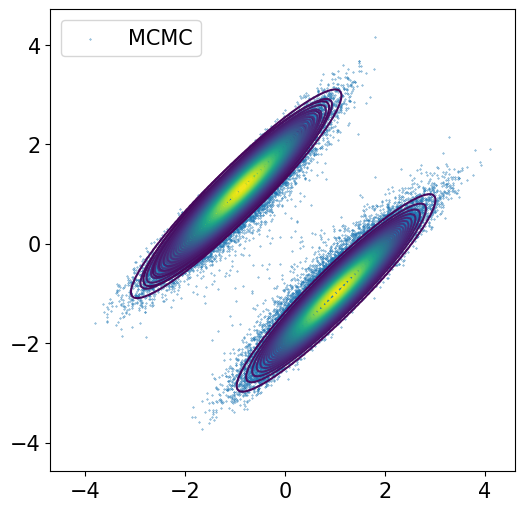

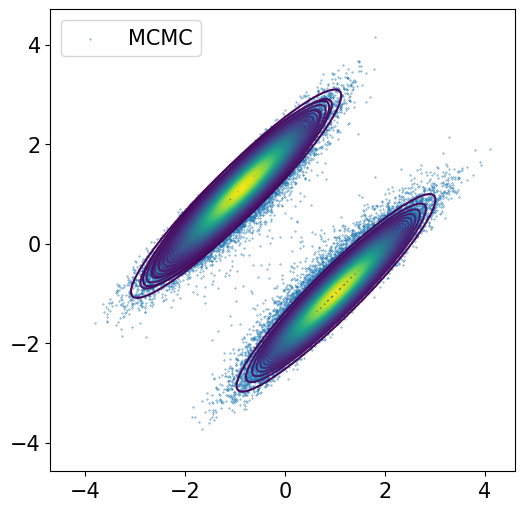

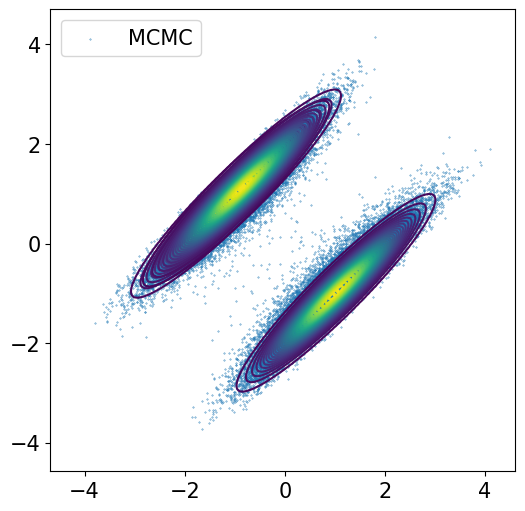

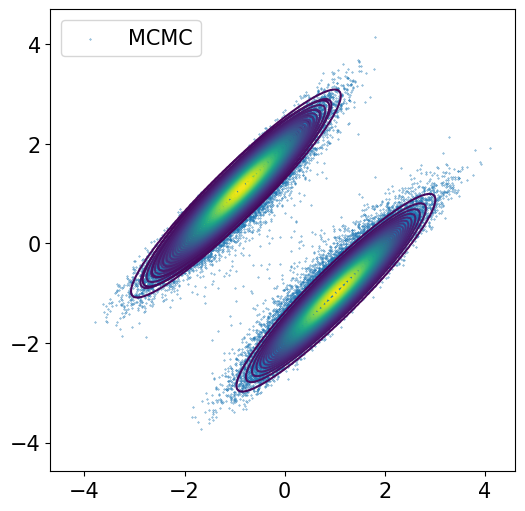

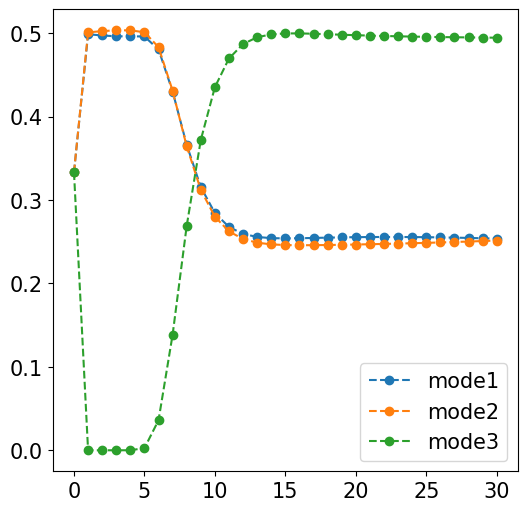

┌ Info: ("prediction step  : θ_mean = ", [-1.1004672640955024 0.8807682114565173; -0.8458134337500137 1.1267185610833135; 1.0223792681477164 -0.9907315344893614], " θ_p_mean = ", [-1.1972015070464954 0.7713556860351871; -0.7017515736662333 1.2489214930020607; 1.046635824286786 -0.9833397808724971])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:560
┌ Info: ("prediction step  : θ_mean = ", [-1.09716944648437 0.8842463789253037; -0.8493704658856717 1.1229556273517514; 1.0223790687422558 -0.9907310236913119], " θ_p_mean = ", [-1.1912312361836366 0.7776861259414874; -0.7083207829523931 1.241950914783577; 1.0466356356481374 -0.9833393121718117])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:560
┌ Info: ("prediction step  : θ_mean = ", [-1.094186001938982 0.8874133705594437; -0.8526540663048419 1.1194692306227902; 1.0223789385832183 -0.9907307651730994], " θ_p_mean = ", [-1.185811804287207 0.783471840365817; -0.7144136739503055

PyObject <matplotlib.legend.Legend object at 0x1dc7fdee0>

In [96]:
function forward(s_param::Setup_Param, θ::Array{Float64,1})
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)

N_y, N_θ = 1, 2
# compute posterior distribution by UKI
update_freq = 1
N_iter = 30
N_modes = 3
θ0_w  = ones(N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

θ0_mean[1, :]    .= [-3.0 ; 0]
θθ0_cov[1, :, :] .= diagm(0.1^2*ones(N_θ))
θ0_mean[2, :]    .= [0.0 ; 3.0]
θθ0_cov[2, :, :] .= diagm(0.1^2*ones(N_θ))
θ0_mean[3, :]    .= [2.0 ; -3.0]
θθ0_cov[3, :, :] .= diagm(0.1^2*ones(N_θ))

s_param_aug = Setup_Param(N_θ, N_y+N_θ)
y_aug = [y ; μ0]
@info Σ_η , Σ0
Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
γ = 1.0
# Δt = γ/(1+γ)
ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")




# visualization 

# Visualize different iterations
for iter  = 1:plot_every:length(ukiobj.θ_mean)
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 
    
    
    if Run_MCMC
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
    end


    # plot UKI results 
    Nx = 100; Ny = 200
    for i =1:N_modes
        uki_θ_mean = ukiobj.θ_mean[iter][i, :]
        uki_θθ_cov = ukiobj.θθ_cov[iter][i, :, :]
        X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
        ax.contour(X, Y, Z, 50)
    end

    ax.legend()
end


nrows, ncols = 1, 1
fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
θ_w = exp.(hcat(ukiobj.logθ_w...))
for i =1:N_modes
    ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
end
ax.legend()

